In [ ]:
from PIL import Image
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [564]:
csv_file_path = '../../dataset/all.csv'
pic_dir_path = '../../dataset/pictures'

In [565]:
from torchvision.transforms import RandomResizedCrop

class RocketDataset(Dataset):
    def __init__(self, csv_file_path, pic_dir_path, resize=1, transform=None):
        self.df = pd.read_csv(csv_file_path)
        self.resize = resize
        self.pic_dir_path = pic_dir_path
        self.transform = transform
 
    def __len__(self):
        return len(self.df)
 
    def __getitem__(self, item):
        img_file_name = self.df.iloc[item, 0]
        img_file_path = f'{self.pic_dir_path}/{img_file_name}'

        image = Image.open(img_file_path).convert("RGB")

        width, height = image.size
        new_width = int(width * self.resize)
        new_height = int(height * self.resize)
  
        crop_transform = RandomResizedCrop((new_height, new_width))
        image = crop_transform(image)

        if self.transform:
            image = self.transform(image)

        image = np.array(image) / 255.0

        chlorophyll_col = self.df.loc[item, 'chlorophyll']
        ammonia_col = self.df.loc[item, 'ammonia']

        chlorophyll_val = np.array(chlorophyll_col, dtype='float32')
        ammonia_val = np.array(ammonia_col, dtype='float32')

        return image, chlorophyll_val, ammonia_val

In [566]:
dataset = RocketDataset(csv_file_path, pic_dir_path, 0.5)
loader = DataLoader(dataset)

  0%|          | 0/1191 [00:00<?, ?it/s]

(384, 512, 3)


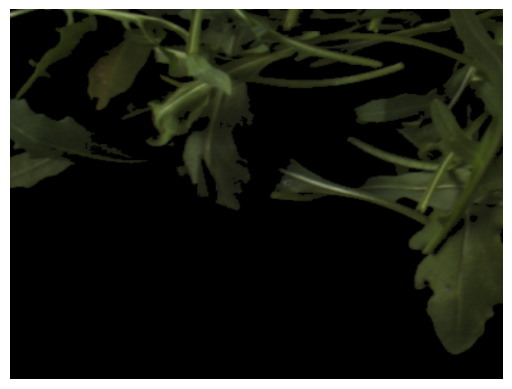

  0%|          | 0/1191 [00:00<?, ?it/s]


In [567]:
for img, chlorophyll, ammonia in tqdm(loader):
    image_numpy = img.numpy()

    print(image_numpy[0].shape)
    
    plt.imshow(image_numpy[0])
    plt.axis('off')
    plt.show()

    break